In this notedbook we will be doing some sentiment analysis in python using two different techniques:

1. VADER - Bag of words approach
2. Roberta Pretrained Model from Huggingface

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
# nltk.download('punkt')
# # nlrk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import re

In [3]:
# Data loading
df = pd.read_csv('reviews_500.csv')
print(df.shape)

(500, 6)


In [14]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...


In [4]:
# basic NLTK
example = df['comments'][60]
print(example)

Needs a lot of maintenance. 4 different keys required to get in and out, kind of excessive. Water pressure is poor. Not very clean. Parking is driving up in a circle 8 times… kind of annoying


In [ ]:
nltk.word_tokenize(example,preserve_line=True)

['Needs',
 'a',
 'lot',
 'of',
 'maintenance.',
 '4',
 'different',
 'keys',
 'required',
 'to',
 'get',
 'in',
 'and',
 'out',
 ',',
 'kind',
 'of',
 'excessive.',
 'Water',
 'pressure',
 'is',
 'poor.',
 'Not',
 'very',
 'clean.',
 'Parking',
 'is',
 'driving',
 'up',
 'in',
 'a',
 'circle',
 '8',
 'times…',
 'kind',
 'of',
 'annoying']

In [ ]:
print(df.shape)

In [ ]:
# Data Cleaning
def clean_text(text):
  if isinstance(text, str):
    text = re.sub(r'[^a-zA-Z\s]', '', text) # remove punctuations
    text = text.lower() # lowercase
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = ' '.join(filtered_tokens)
    return text
  return ''

df['cleaned_comments'] = df['comments'].apply(clean_text)

In [ ]:
# Data Preparation
df = df[df['cleaned_comments'] != ''] # removing null reviews
X = df['cleaned_comments']
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
# Text Proprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  tokens = word_tokenize(text)
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
  return ' '.join(filtered_tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [ ]:
# Model Training
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression()
model.fit(X_train_vec, y_train)

In [ ]:
# Test Set Evaluation
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# VADER Model

# RoBERTa Model

In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [15]:
from tqdm import tqdm

In [6]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.959496, 'roberta_neu': 0.035880398, 'roberta_pos': 0.004623604}


In [10]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['comments']
    myid = row['id']

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Storing Results
    res[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

  8%|▊         | 41/500 [00:12<02:15,  3.39it/s]

Broke for id 32112250


 93%|█████████▎| 463/500 [02:42<00:13,  2.69it/s]

Broke for id 83038325


100%|██████████| 500/500 [02:54<00:00,  2.87it/s]


In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = df.merge(results_df, how='left')

In [19]:
results_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,roberta_neg,roberta_neu,roberta_pos
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...,0.001197,0.008272,0.990532
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...,0.194853,0.712344,0.092803
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...,0.000973,0.011327,0.987700
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...,0.001322,0.008167,0.990511
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...,0.001646,0.009582,0.988771


In [23]:
results_df.head().to_csv('reviews_500_results.csv', index=False)

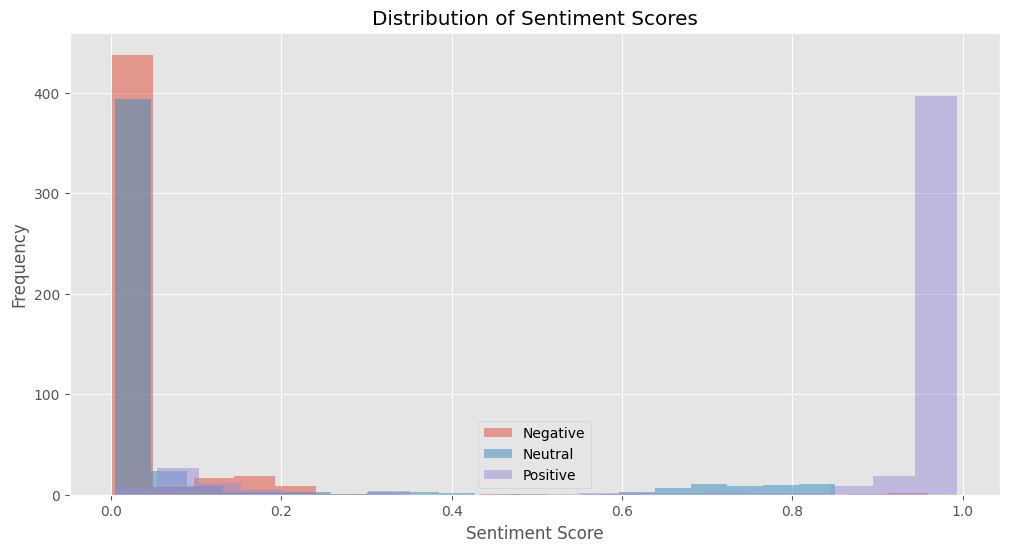

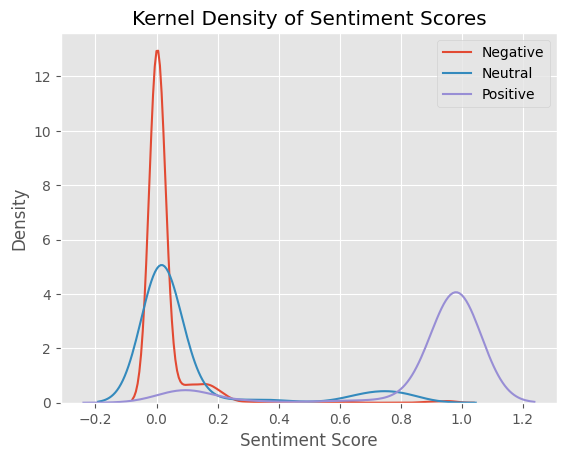

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'res' dictionary stores sentiment scores as:
# res = {review_id: {'roberta_neg': score, 'roberta_neu': score, 'roberta_pos': score}}

# Create a list of sentiment scores for each category
neg_scores = [d['roberta_neg'] for d in res.values()]
neu_scores = [d['roberta_neu'] for d in res.values()]
pos_scores = [d['roberta_pos'] for d in res.values()]

# Plotting histograms
plt.figure(figsize=(12, 6))
plt.hist(neg_scores, bins=20, alpha=0.5, label='Negative')
plt.hist(neu_scores, bins=20, alpha=0.5, label='Neutral')
plt.hist(pos_scores, bins=20, alpha=0.5, label='Positive')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Alternatively, using seaborn for kernel density plots
sns.kdeplot(neg_scores, label='Negative')
sns.kdeplot(neu_scores, label='Neutral')
sns.kdeplot(pos_scores, label='Positive')
plt.title('Kernel Density of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

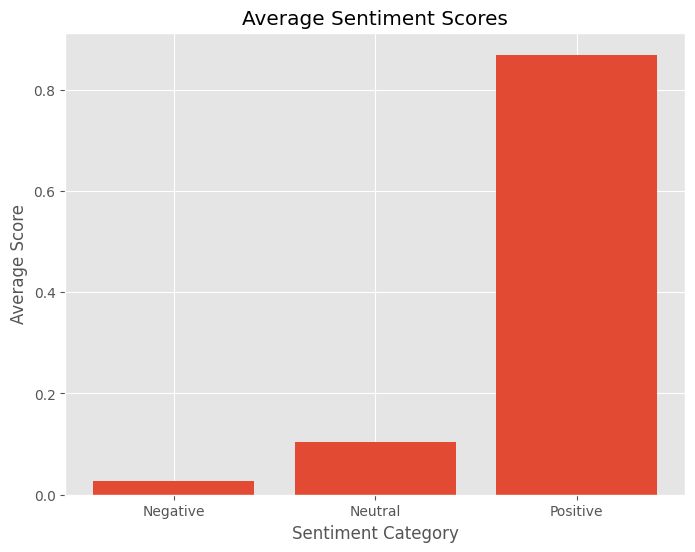

In [21]:
import numpy as np

# Calculate average sentiment scores
avg_neg = np.mean(neg_scores)
avg_neu = np.mean(neu_scores)
avg_pos = np.mean(pos_scores)

# Plotting bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Negative', 'Neutral', 'Positive'], [avg_neg, avg_neu, avg_pos])
plt.title('Average Sentiment Scores')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.show()

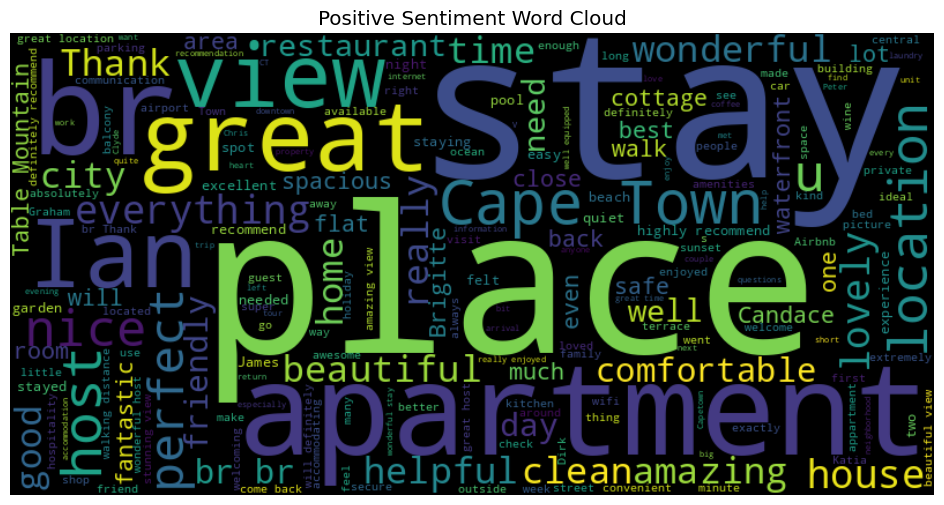

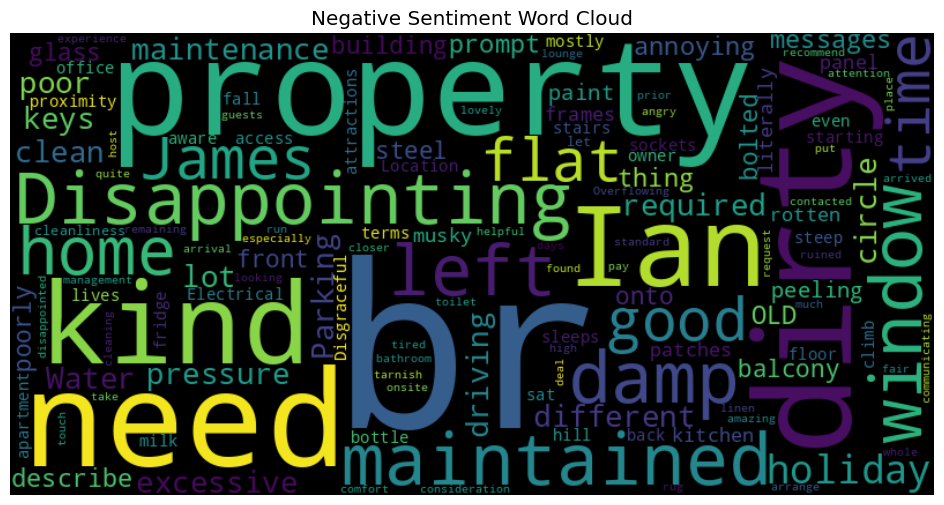

In [22]:
from wordcloud import WordCloud

# Assuming you have the original review text in a column called 'comments' in your DataFrame
# and 'results_df' contains sentiment scores

# Create separate lists of reviews for each sentiment category
positive_reviews = results_df[results_df['roberta_pos'] > 0.5]['comments'].tolist()
negative_reviews = results_df[results_df['roberta_neg'] > 0.5]['comments'].tolist()

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400).generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400).generate(' '.join(negative_reviews))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

<br/>The apartment is spacious with plenty of room for a couple.  You must provide your own paper goods, including toilet paper and paper towels. You'll need your own laundry soap and dryer sheets.  Load shedding (temporary electricity cut-off) is a fact of life in South Africa and will likely affect your stay.  With no electricity you may be eating out, not cooking at the apartment, so don't buy too many groceries up front.  Besides, there are so many good restaurants in Cape Town!  . Error: The expanded size of the tensor (515) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 515].  Tensor sizes: [1, 514]
<br/>TV - channels are a bit limited but why would you watch TV.. Error: The expanded size of the tensor (603) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 603].  Tensor sizes: [1, 514]


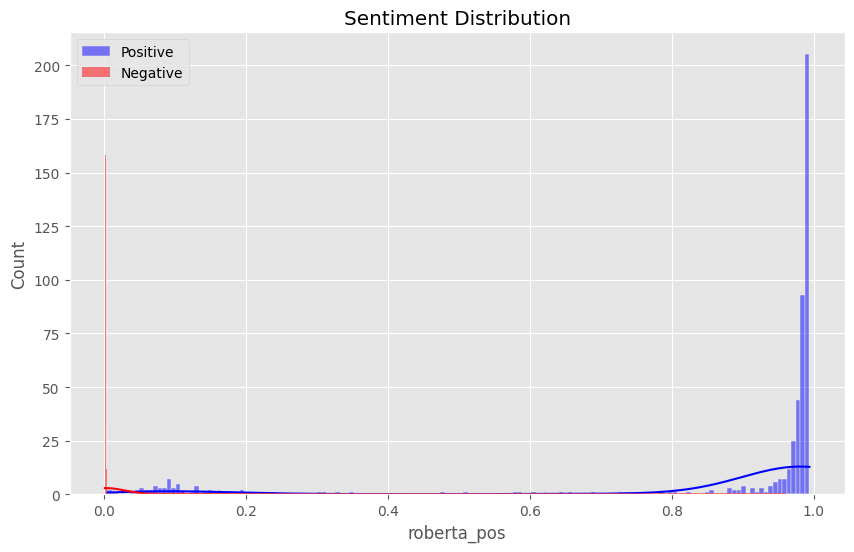

ModuleNotFoundError: No module named 'streamlit'

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import logging

# Logging setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load data
# file_path = os.getenv('REVIEWS_FILE_PATH', 'reviews_500.csv')
# if not os.path.exists(file_path):
#     raise FileNotFoundError(f"File not found: {file_path}")
df = pd.read_csv('reviews_500.csv')

# Initialize model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Sentiment analysis function
def polarity_scores_roberta(text):
    try:
        encoded_text = tokenizer(text, return_tensors='pt')
        output = model(**encoded_text)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        return {
            'roberta_neg': scores[0],
            'roberta_neu': scores[1],
            'roberta_pos': scores[2]
        }
    except Exception as e:
        logger.error(f"Error processing text: {text}. Error: {e}")
        return {'roberta_neg': np.nan, 'roberta_neu': np.nan, 'roberta_pos': np.nan}

# Process rows
def process_row(row):
    text = row['comments']
    result = polarity_scores_roberta(text)
    result['id'] = row['id']
    return pd.Series(result)

results_df = df.apply(process_row, axis=1)

# Merge results
final_df = pd.merge(df, results_df, on='id', how='left')

# Visualize results
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(final_df['roberta_pos'], kde=True, color='blue', label='Positive', ax=ax)
sns.histplot(final_df['roberta_neg'], kde=True, color='red', label='Negative', ax=ax)
ax.set_title('Sentiment Distribution')
ax.legend()
plt.show()

# Streamlit integration
import streamlit as st
import plotly.express as px
st.title("Sentiment Analysis App")
st.write(final_df[['id', 'comments', 'roberta_pos', 'roberta_neg', 'roberta_neu']])
st.plotly_chart(px.histogram(final_df, x='roberta_pos', title="Positive Sentiment Distribution"))